In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, f1_score, recall_score
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder


## Prediction with XGboositing model

In [4]:
df = pd.read_csv("data/turtles_cleaned.csv")
df

,CaptureSite,ForagingGround,Species,CCL_cm,CCW_cm,Weight_Kg,CaptureSiteCategory,CalendarWeek
0,CaptureSite_0,Ocean,Species_6,64.70,62.60,NaN,CaptureSiteCategory_2,50
1,CaptureSite_0,Ocean,Species_6,35.85,31.35,NaN,CaptureSiteCategory_2,42
2,CaptureSite_0,Ocean,Species_5,51.80,49.20,NaN,CaptureSiteCategory_2,43
3,CaptureSite_0,Ocean,Species_6,60.50,59.00,NaN,CaptureSiteCategory_2,10
4,CaptureSite_0,Ocean,Species_5,34.70,33.00,NaN,CaptureSiteCategory_2,31
...,...,...,...,...,...,...,...,...
18057,CaptureSite_9,Ocean,Species_5,57.13,50.57,21.09,CaptureSiteCategory_1,50
18058,CaptureSite_9,Ocean,Species_6,42.07,38.37,9.02,CaptureSiteCategory_1,50
18059,CaptureSite_9,Ocean,Species_5,57.20,52.30,NaN,CaptureSiteCategory_1,51
18060,CaptureSite_9,Ocean,Species_5,51.90,48.50,NaN,CaptureSiteCategory_1,51


In [5]:
df_2 = df.loc[df["CaptureSiteCategory"] == "CaptureSiteCategory_3"].copy()
df_2

,CaptureSite,ForagingGround,Species,CCL_cm,CCW_cm,Weight_Kg,CaptureSiteCategory,CalendarWeek
13246,CaptureSite_26,Ocean,Species_5,39.00,38.5,NaN,CaptureSiteCategory_3,34
13247,CaptureSite_26,Ocean,Species_5,91.00,88.5,NaN,CaptureSiteCategory_3,35
13248,CaptureSite_26,Ocean,Species_6,30.50,27.8,NaN,CaptureSiteCategory_3,24
13249,CaptureSite_26,Ocean,Species_5,35.50,36.2,NaN,CaptureSiteCategory_3,33
13250,CaptureSite_26,Ocean,Species_5,47.60,43.6,NaN,CaptureSiteCategory_3,2
...,...,...,...,...,...,...,...,...
13318,CaptureSite_26,Ocean,Species_5,76.50,70.4,38.50,CaptureSiteCategory_3,17
13319,CaptureSite_26,Ocean,Species_5,71.00,64.5,28.00,CaptureSiteCategory_3,32
13320,CaptureSite_26,Ocean,Species_5,56.40,53.2,17.71,CaptureSiteCategory_3,36
13321,CaptureSite_26,Ocean,Species_5,20.33,19.5,0.95,CaptureSiteCategory_3,38


In [6]:
# ------------------------------------------------------------
df = df.drop("CaptureSite", axis = 1)
df

,ForagingGround,Species,CCL_cm,CCW_cm,Weight_Kg,CaptureSiteCategory,CalendarWeek
0,Ocean,Species_6,64.70,62.60,NaN,CaptureSiteCategory_2,50
1,Ocean,Species_6,35.85,31.35,NaN,CaptureSiteCategory_2,42
2,Ocean,Species_5,51.80,49.20,NaN,CaptureSiteCategory_2,43
3,Ocean,Species_6,60.50,59.00,NaN,CaptureSiteCategory_2,10
4,Ocean,Species_5,34.70,33.00,NaN,CaptureSiteCategory_2,31
...,...,...,...,...,...,...,...
18057,Ocean,Species_5,57.13,50.57,21.09,CaptureSiteCategory_1,50
18058,Ocean,Species_6,42.07,38.37,9.02,CaptureSiteCategory_1,50
18059,Ocean,Species_5,57.20,52.30,NaN,CaptureSiteCategory_1,51
18060,Ocean,Species_5,51.90,48.50,NaN,CaptureSiteCategory_1,51


In [14]:

target = "CaptureSiteCategory"
X = df.drop(columns=[target])
y = df[target]

# ------------------------------------------------------------
# 2. Encode target labels into integers
# ------------------------------------------------------------
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# ------------------------------------------------------------
# 3. Identify numeric & categorical columns
# ------------------------------------------------------------
numeric_cols = X.select_dtypes(include=["float64", "int64"]).columns.tolist()
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()

# ------------------------------------------------------------
# 4. Preprocessing pipelines
# ------------------------------------------------------------
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean"))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

# ------------------------------------------------------------
# 5. XGBoost model inside a pipeline
# ------------------------------------------------------------
model = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="multi:softprob",
    eval_metric="mlogloss",
    tree_method="hist",
    random_state=42
)

clf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", model)
])

# ------------------------------------------------------------
# 6. Train-test split
# ------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded,
    test_size=0.3,
    random_state=42,
    stratify=y_encoded
)

# ------------------------------------------------------------
# 7. Train model
# ------------------------------------------------------------
clf.fit(X_train, y_train)

# ------------------------------------------------------------
# 8. Predictions & evaluation
# ------------------------------------------------------------
y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# ------------------------------------------------------------
# 9. Example prediction on new data
# ------------------------------------------------------------
example = pd.DataFrame([{
    "CaptureSite": "CaptureSite_0",
    "ForagingGround": "Ocean",
    "Species": "Species_6",
    "CCL_cm": 60.0,
    "CCW_cm": 58.0,
    "Weight_Kg": 25.0,
    "CalendarWeek": 32
}])

pred_encoded = clf.predict(example)
pred_label = le.inverse_transform(pred_encoded)

print("Predicted CaptureSiteCategory:", pred_label[0])

Accuracy: 0.7052961801070308

Classification Report:

                       precision    recall  f1-score   support

CaptureSiteCategory_0       0.74      0.99      0.85      2541
CaptureSiteCategory_1       0.53      0.36      0.43       694
CaptureSiteCategory_2       0.69      0.82      0.75      1277
CaptureSiteCategory_3       0.00      0.00      0.00        23
CaptureSiteCategory_4       0.26      0.01      0.01       884

             accuracy                           0.71      5419
            macro avg       0.44      0.44      0.41      5419
         weighted avg       0.62      0.71      0.63      5419

Predicted CaptureSiteCategory: CaptureSiteCategory_1


/Users/filipo/Documents/NeueFische/Turtles-ML-project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/filipo/Documents/NeueFische/Turtles-ML-project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/filipo/Documents/NeueFische/Turtles-ML-project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` paramete

## Selection of the best Hyperparameters

In [8]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    "model__n_estimators": [200, 400, 600],
    "model__learning_rate": [0.01, 0.05, 0.1, 0.2],
    "model__max_depth": [4, 6, 8],
    "model__subsample": [0.7, 0.8, 1.0],
    "model__colsample_bytree": [0.7, 0.8, 1.0],
    "model__gamma": [0, 1, 5],
    "model__reg_alpha": [0, 0.1, 0.5],
    "model__reg_lambda": [1, 5, 10]
}

search = RandomizedSearchCV(
    clf,
    param_distributions=param_grid,
    n_iter=30,                # number of random combinations
    scoring="accuracy",       # or "f1_macro" for multiclass
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

search.fit(X_train, y_train)
print("Best parameters:", search.best_params_)
print("Best CV score:", search.best_score_)


Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END model__colsample_bytree=1.0, model__gamma=1, model__learning_rate=0.05, model__max_depth=8, model__n_estimators=600, model__reg_alpha=0, model__reg_lambda=10, model__subsample=0.8; total time=   1.3s
[CV] END model__colsample_bytree=1.0, model__gamma=1, model__learning_rate=0.05, model__max_depth=8, model__n_estimators=600, model__reg_alpha=0, model__reg_lambda=10, model__subsample=0.8; total time=   1.2s
[CV] END model__colsample_bytree=1.0, model__gamma=1, model__learning_rate=0.05, model__max_depth=8, model__n_estimators=600, model__reg_alpha=0, model__reg_lambda=10, model__subsample=0.8; total time=   1.3s
[CV] END model__colsample_bytree=1.0, model__gamma=1, model__learning_rate=0.05, model__max_depth=8, model__n_estimators=600, model__reg_alpha=0, model__reg_lambda=10, model__subsample=0.8; total time=   1.3s
[CV] END model__colsample_bytree=1.0, model__gamma=1, model__learning_rate=0.05, model__max_depth=8, m

## Confusion matrix for multiclass performance

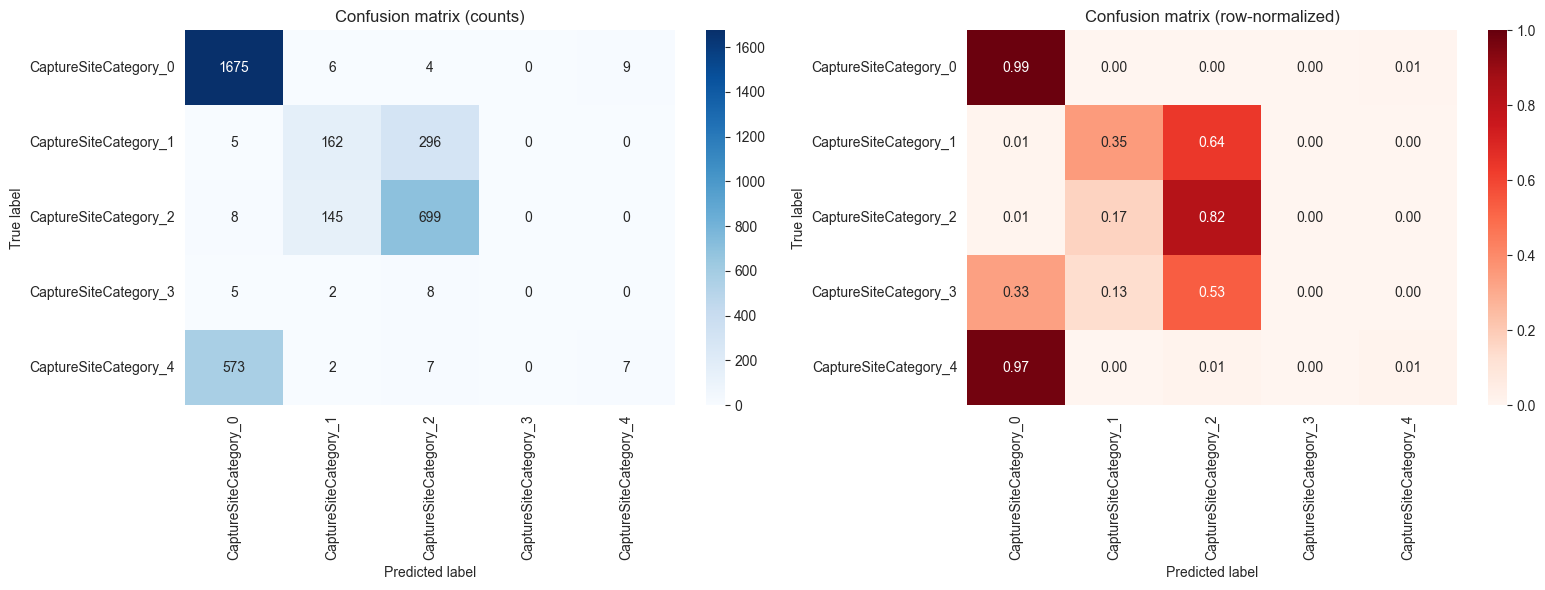

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Normalize by true class counts (recall-oriented view)
cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Raw counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_, ax=axes[0])
axes[0].set_title('Confusion matrix (counts)')
axes[0].set_xlabel('Predicted label')
axes[0].set_ylabel('True label')

# Row-normalized (recall)
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Reds',
            xticklabels=le.classes_, yticklabels=le.classes_, ax=axes[1], vmin=0, vmax=1)
axes[1].set_title('Confusion matrix (row-normalized)')
axes[1].set_xlabel('Predicted label')
axes[1].set_ylabel('True label')

plt.tight_layout()
plt.show()


In [ ]:
# Accuracy, F1 and Recall
f1Score = f1_score(y_test,y_pred,average='weighted')
acc = accuracy_score(y_test, y_pred)
rec = recall_score(y_test, y_pred, average='weighted')

# ROC curves

In [10]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# 1. Get class names and number of classes
classes = le.classes_
n_classes = len(classes)

# 2. Get predicted probabilities from pipeline
y_proba = clf.predict_proba(X_test)   # shape (n_samples, n_classes)

# 3. Binarize true labels for multiclass AUC calculation
y_test_binarized = label_binarize(y_test, classes=np.arange(n_classes))  # shape (n_samples, n_classes)

# 4. Per-class AUC (One-vs-Rest)
per_class_auc = {}
for i, cls in enumerate(classes):
    try:
        score = roc_auc_score(y_test_binarized[:, i], y_proba[:, i])
    except ValueError:
        score = np.nan
    per_class_auc[cls] = score

# 5. Micro, Macro, Weighted AUC
# micro: treat all classes together
micro_auc = roc_auc_score(y_test_binarized, y_proba, average="micro")
macro_auc = roc_auc_score(y_test_binarized, y_proba, average="macro")
weighted_auc = roc_auc_score(y_test_binarized, y_proba, average="weighted")

print("Per-class AUC (OvR):")
for cls, a in per_class_auc.items():
    print(f"  {cls}: {a:.3f}")

print(f"\nMicro AUC:   {micro_auc:.3f}")
print(f"Macro AUC:   {macro_auc:.3f}")
print(f"Weighted AUC:{weighted_auc:.3f}")


Per-class AUC (OvR):
  CaptureSiteCategory_0: 0.871
  CaptureSiteCategory_1: 0.911
  CaptureSiteCategory_2: 0.941
  CaptureSiteCategory_3: 0.606
  CaptureSiteCategory_4: 0.763

Micro AUC:   0.936
Macro AUC:   0.818
Weighted AUC:0.874


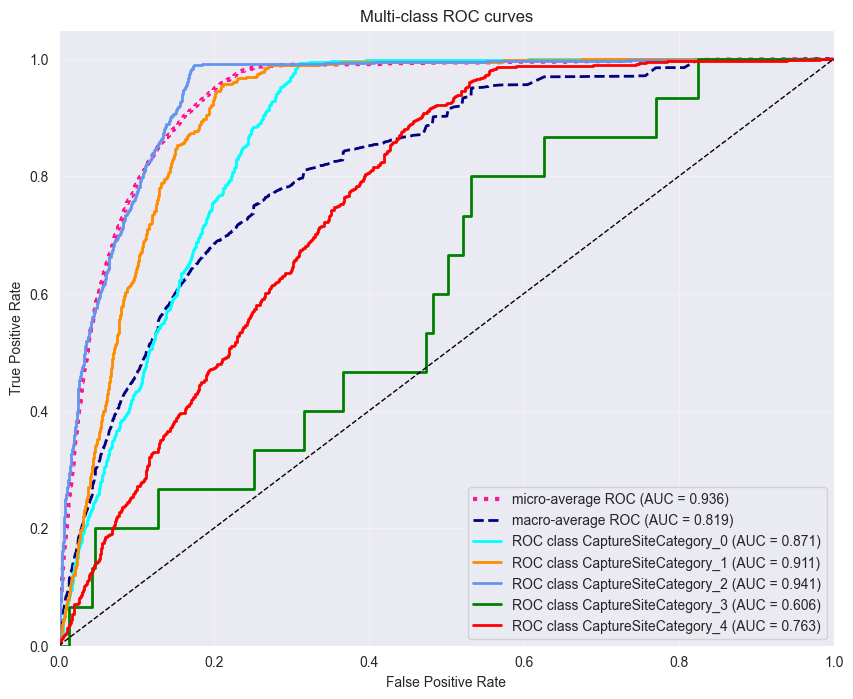

In [11]:
from itertools import cycle
from sklearn.metrics import roc_curve

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    # If a class has no positives in test, skip plotting that class
    if np.sum(y_test_binarized[:, i]) == 0:
        fpr[i], tpr[i], roc_auc[i] = np.array([0.0, 1.0]), np.array([0.0, 1.0]), np.nan
        continue
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC by interpolating
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes) if isinstance(fpr[i], np.ndarray)]))
mean_tpr = np.zeros_like(all_fpr)
valid_classes = [i for i in range(n_classes) if isinstance(fpr[i], np.ndarray)]
for i in valid_classes:
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= len(valid_classes)
fpr["macro"], tpr["macro"] = all_fpr, mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot
plt.figure(figsize=(10, 8))
plt.plot(fpr["micro"], tpr["micro"],
         label=f"micro-average ROC (AUC = {roc_auc['micro']:.3f})",
         color="deeppink", linestyle=":", linewidth=3)

plt.plot(fpr["macro"], tpr["macro"],
         label=f"macro-average ROC (AUC = {roc_auc['macro']:.3f})",
         color="navy", linestyle="--", linewidth=2)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple'])
for i, color in zip(range(n_classes), colors):
    if np.isnan(roc_auc[i]):
        continue
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC class {classes[i]} (AUC = {roc_auc[i]:.3f})')

plt.plot([0, 1], [0, 1], "k--", lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-class ROC curves")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()
